In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import struct
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)


In [333]:
name = 'max_flight'
log = '../../cats-logs/log_parsing/output/' + name + '/processed/'
log_imu = log + name + ' - imu_processed.csv'
log_baro = log + name + ' - baro_processed.csv'
log_filtered = log + name + ' - filtered_data_info_processed.csv'

imu_data_df = pd.read_csv(log_imu) 
baro_data_df = pd.read_csv(log_baro) 
filtered_data_df = pd.read_csv(log_filtered) 

imu_0 = imu_data_df.loc[imu_data_df['id'] == 'IMU0']
imu_1 = imu_data_df.loc[imu_data_df['id'] == 'IMU1']

baro_0 = baro_data_df.loc[baro_data_df['id'] == 'BARO0']
baro_1 = baro_data_df.loc[baro_data_df['id'] == 'BARO1']
baro_2 = baro_data_df.loc[baro_data_df['id'] == 'BARO2']


In [334]:
def prediction_step(x_bar, u_bar, P_bar, Ts, Q):
    # This needs to be moved in the include 
    Ad = np.array([[1, Ts, Ts*Ts/2],[0, 1, Ts], [0, 0, 1]])
    Gd = np.array([[Ts, Ts*Ts/2], [1, Ts], [0, 1]])
    Bd = np.array([[Ts*Ts/2], [Ts], [0]])
    # finished including
    
    x_hat = np.matmul(Ad, x_bar) + Bd * u_bar
    P_hat = np.matmul(np.matmul(Ad, P_bar), np.transpose(Ad)) + np.matmul(np.matmul(Gd, Q), np.transpose(Gd))
    return x_hat, P_hat

def update_step_sim(x_hat, P_hat, measurement, R):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]])
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    #K = np.array([[0.0090859386, 0.0090859386, 0.0090859386], [0.0125381065, 0.0125381065, 0.0125381065], [0.000748688836, 0.000748688836, 0.000748688836]])
    #K = np.array([[0.00900859386, 0.00900859386, 0.00900859386], [0.0123381065, 0.0123381065, 0.0123381065], [0.000448688836, 0.000448688836, 0.000448688836]])
    #K = np.array([[0.00908229, 0.00908229, 0.00908229], [0.01253863, 0.01253863, 0.01253863], [0.00072149, 0.00072149, 0.00072149]])
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar, K

def calculate_height(P0, P, T):

    return (((P0/P)**(1/5.257)-1)*(T+273.15)/0.0065)
    


In [340]:
import numpy as np
Ts = 1/100
x_bar_old = np.array([[0],[10],[0]])
x_bar_new = np.array([[0],[10],[0]])
P_bar_old = np.array([[0.01, 0, 0],[0, 0.01, 0], [0, 0, 0.01]])
P_bar_new = np.array([[0.01, 0, 0],[0, 0.01, 0], [0, 0, 0.01]])
P0 = np.mean([[baro_0.iloc[0].P], [baro_1.iloc[0].P], [baro_2.iloc[0].P]])
time = np.zeros(len(baro_0))
height_old = np.zeros(len(baro_0))
velocity_old = np.zeros(len(baro_0))
acc_offset_old = np.zeros(len(baro_0))
height_new = np.zeros(len(baro_0))
velocity_new = np.zeros(len(baro_0))
acc_offset_new = np.zeros(len(baro_0))
agl = np.zeros(len(baro_0))
acc = np.zeros(len(baro_0))
i = 0

R_old = 9*np.eye(3)
Q_old = np.array([[0.004, 0], [0, 0.000001]])

R_new = 90*np.eye(3)
Q_new = np.array([[0.00004, 0], [0, 0.000001]])




for k in range(len(baro_2)):
    
    y1 = calculate_height(P0, float(baro_0.iloc[k].P), 25.0)
    y2 = calculate_height(P0, float(baro_1.iloc[k].P), 25.0)
    y3 = calculate_height(P0, float(baro_2.iloc[k].P), 25.0)
    y = np.array([[y1], [y2], [y3]])
    #print(y)
    u = -imu_0.iloc[k].Ay*9.81 - 9.81
    #print(u)

        
    
#    if ((float(timestamp) > 90000) and (float(timestamp) < 90100)):
#        print(sensor_readings["baro_0"])
        

    [x_hat_old, P_hat_old] = prediction_step(x_bar_old, u, P_bar_old, Ts, Q_old)
    [x_hat_new, P_hat_new] = prediction_step(x_bar_new, u, P_bar_new, Ts, Q_new)
    if(k < 30000):
        [x_bar_old, P_bar_old, K] = update_step_sim(x_hat_old, P_hat_old, y, R_old)
        [x_bar_new, P_bar_new, K] = update_step_sim(x_hat_new, P_hat_new, y, R_new)
    else:
        x_bar_old = x_hat_old
        x_bar_new = x_hat_new

    agl[k] = y1
    acc[k] = u
    height_old[k] = x_bar_old[0]
    velocity_old[k] = x_bar_old[1]
    acc_offset_old[k] = x_bar_old[2]
    height_new[k] = x_bar_new[0]
    velocity_new[k] = x_bar_new[1]
    acc_offset_new[k] = x_bar_new[2]
    height_new[k] = x_bar_new[0]
    velocity_new[k] = x_bar_new[1]
    acc_offset_new[k] = x_bar_new[2]
    time[k] = float(baro_2.iloc[k].ts)

K

array([[2.04415609e-03, 2.04415609e-03, 2.04415609e-03],
       [6.28714827e-04, 6.28714827e-04, 6.28714827e-04],
       [6.06711742e-05, 6.06711742e-05, 6.06711742e-05]])

In [345]:
plot_limits = [87500, 92500]
#plot_limits = [0, 2000]
plot_limits = [0, 3000]

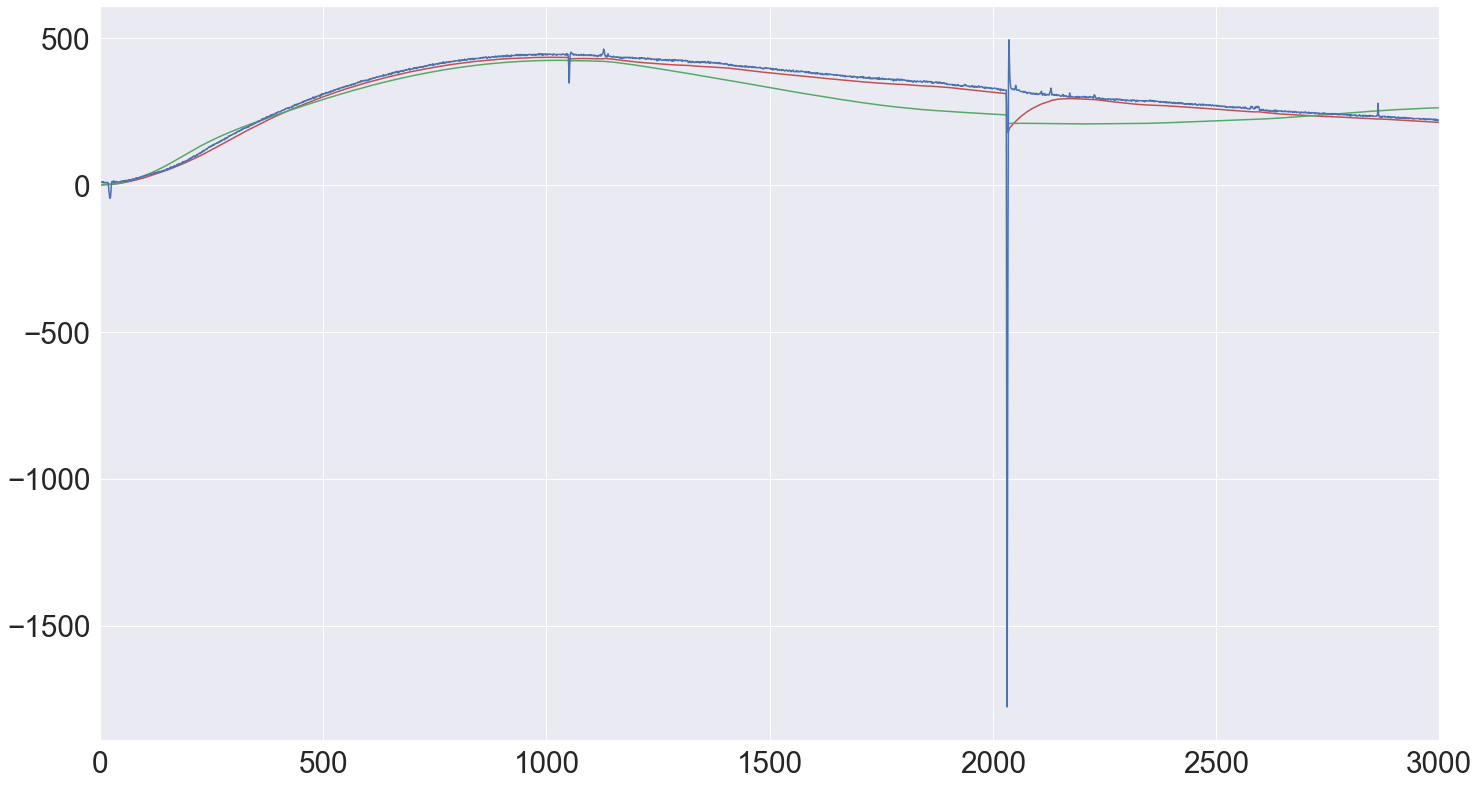

In [346]:
plt.plot(height_old, 'r')
plt.plot(height_new, 'g')
plt.plot(agl, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

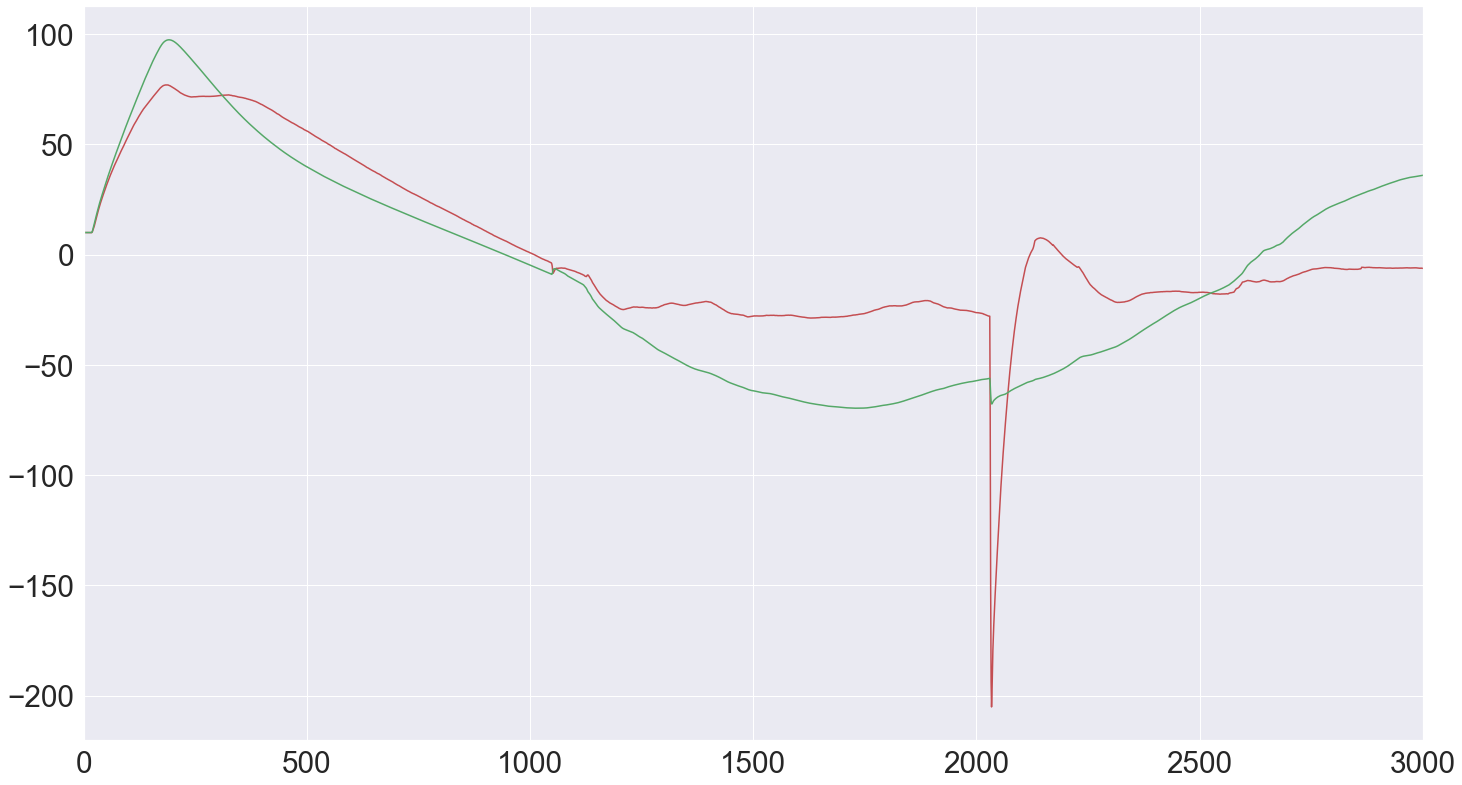

In [347]:
plt.plot(velocity_old, 'r')
plt.plot(velocity_new, 'g')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

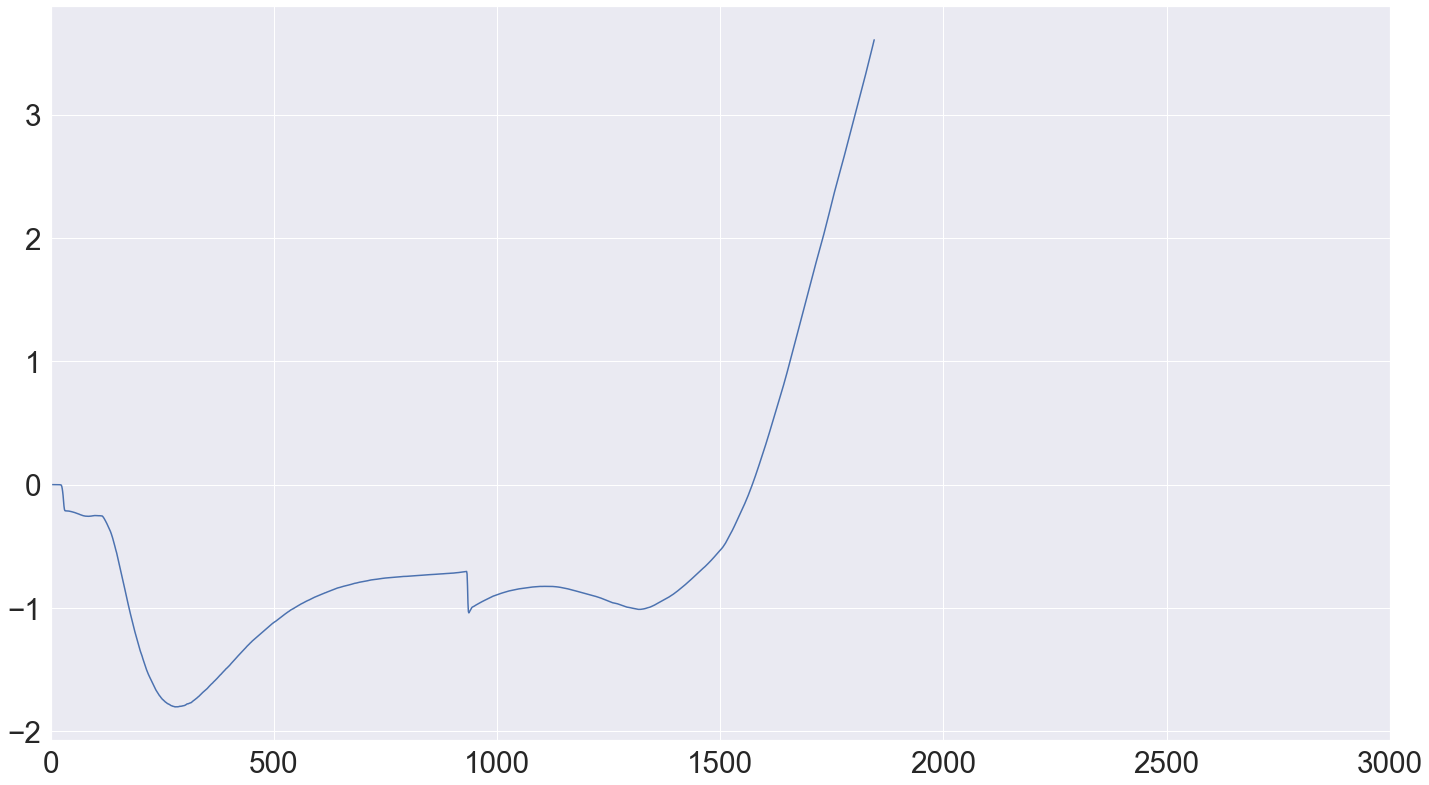

In [348]:
plt.plot(acc_offset, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

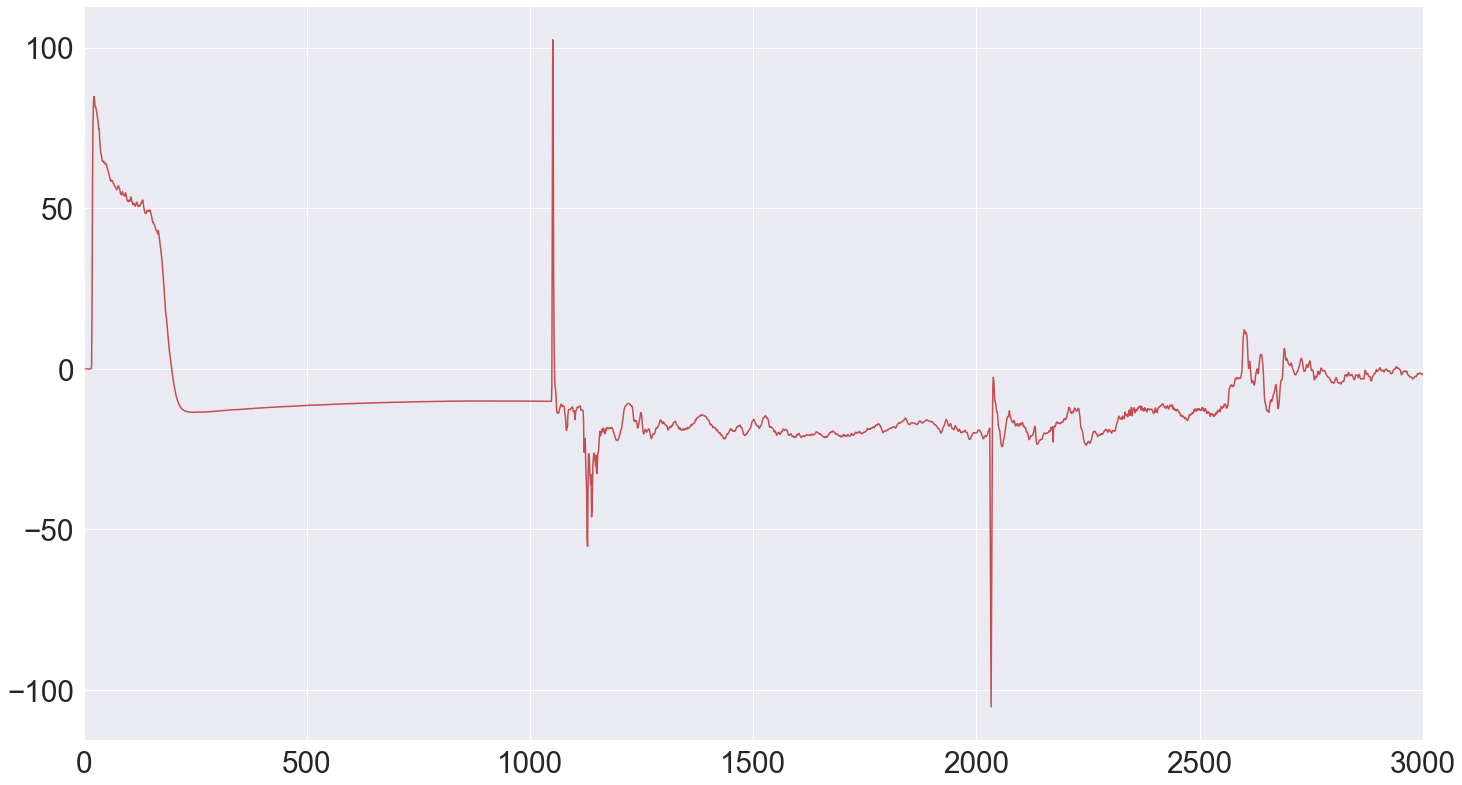

In [349]:
plt.plot(acc, 'r')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

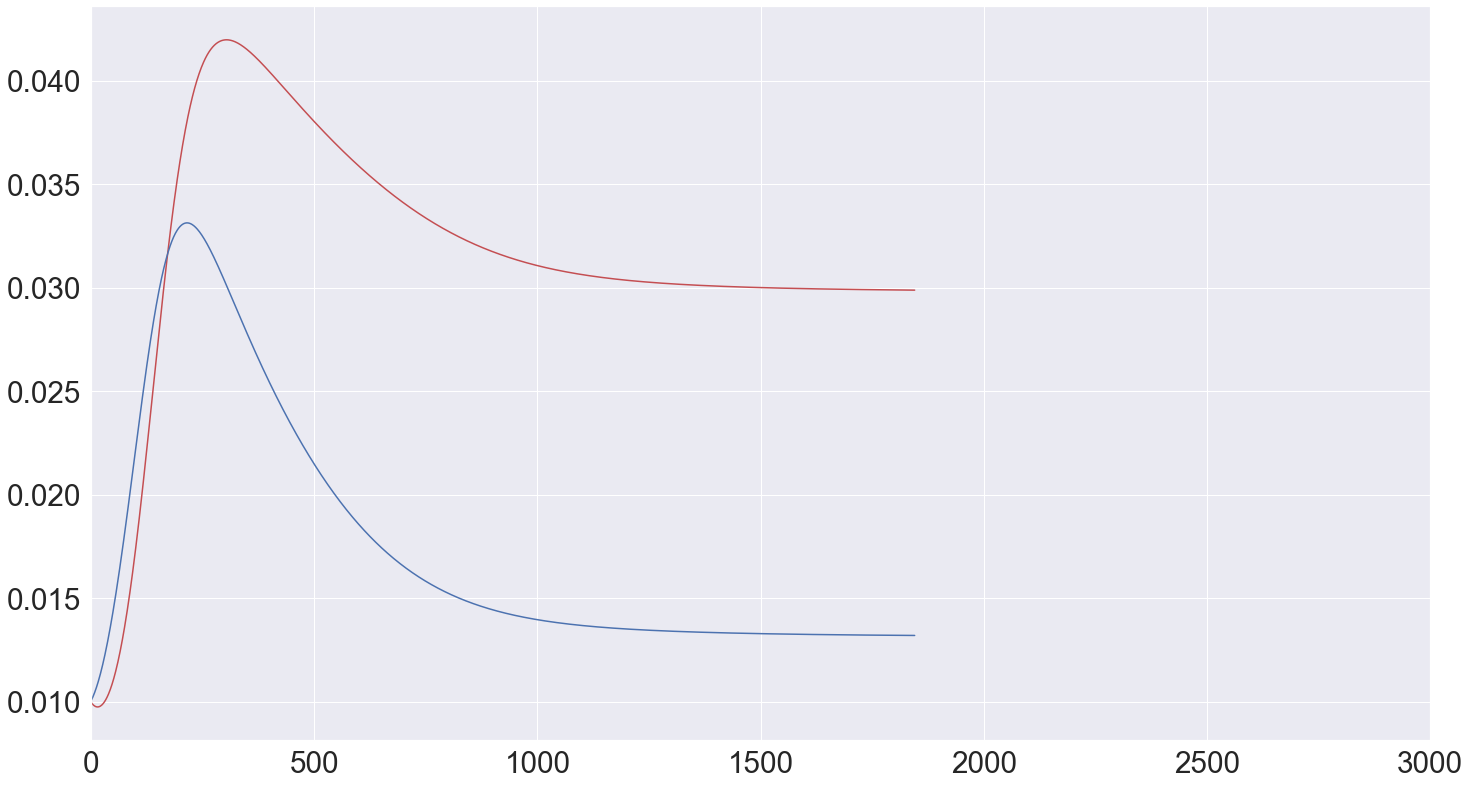

In [350]:
plt.plot(cov_height, 'r')
plt.plot(cov_vel, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

In [55]:
max(velocity)

79.19137720442643

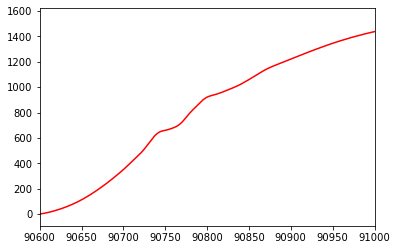

In [41]:
plt.plot(height, 'r')
axes = plt.gca()
axes.set_xlim([90600, 91000])
plt.show()